In [197]:
import heapq
import os.path
import re
from glob import glob
from operator import itemgetter
from optparse import OptionParser

import matplotlib.pyplot as plt
import numpy as np
import torch
from momentum_model import MomentumModel
from network import SimpleNet
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision.transforms import functional

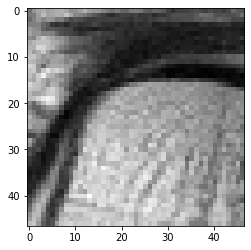

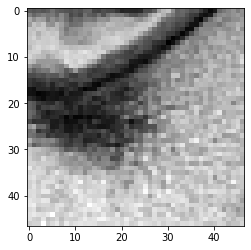

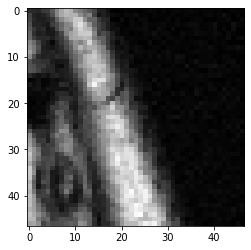

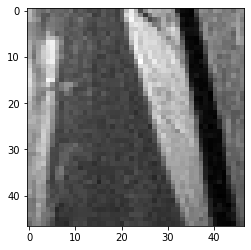

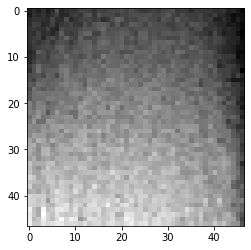

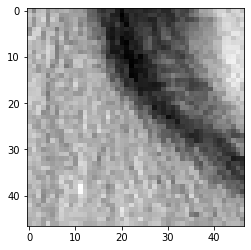

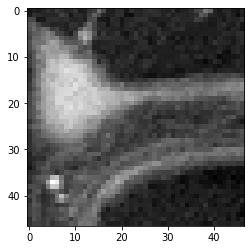

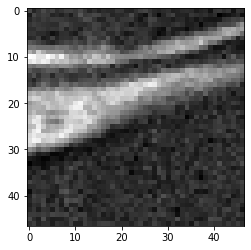

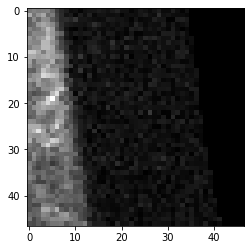

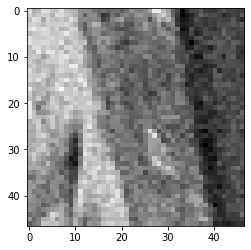

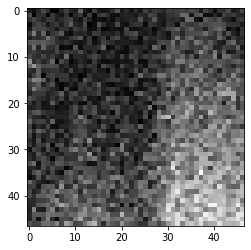

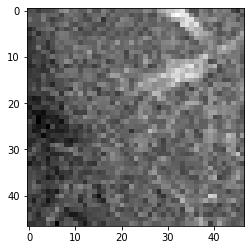

In [198]:
input_paths = [
            "/home/asdegoyeneche/UFLoss/fastmri_val_images/file1000153_4.npy",
            "/home/asdegoyeneche/UFLoss/fastmri_val_images/file1001059_2.npy",
        ]
patch_centers = [(300, 120), (310, 200), (280, 290),
                         (450, 120), (95, 180), (200, 220)]


for path in input_paths:
    im = np.load(path)
    for center in patch_centers:
        plt.figure()
        patch = im[center[0] - 47//2:center[0] + 47//2+1, center[1] - 47//2:center[1] + 47//2+1]
        plt.imshow(np.abs(patch), cmap='gray')
        
        
#TODO normalize (image) these to 95% and make sure distributions match

In [199]:
class EmbeddingsTopK:

    def __init__(self, reference_embedding, reference_image,
                 embedding_index, centers_x, centers_y, max_to_keep=20):

        self.embedding = reference_embedding
        self.heap = []
        self.max_to_keep = max_to_keep

        self.centers_x = centers_x
        self.centers_y = centers_y

        self.patch = self.get_patch(torch.from_numpy(np.abs(reference_image)), embedding_index)

    def push(self, score, image_patch):
        # Avoid exact same score with some random in very low decimal points
        heapq.heappush(self.heap, (-score + np.random.random() * 1e-10, image_patch))

        if len(self.heap) >= self.max_to_keep:
            worst_index, _ = self.worst_score
            del self.heap[worst_index]
            try:
                heapq.heapify(self.heap)  # Should not be needed if we are deleting a leaf
            except Exception:
                print("uh oh")
                print([item[0] for item in self.heap])

                a = 1

    def push_batch(self, batch_embeddings, batch_images):
        batch_size, feature_dim, rows, cols = batch_embeddings.shape
        batch_scores = torch.sum(self.embedding[None, :, None, None] * batch_embeddings, dim=1)
        dropout = 0.0
        if dropout:
            # Add some random sampling to avoid getting many images from same patient and area
            # Keep something like 50% of the patches (however, we will get different results every time)
            batch_scores = dropout * torch.nn.functional.dropout(batch_scores, p=dropout, inplace=True)
        batch_images = batch_images.norm(dim=1)  # Complex to Abs

        for value, index in zip(*torch.topk(batch_scores.view(-1), self.max_to_keep)):
            image_index = index // (rows * cols)
            index = index - image_index * rows * cols
            row, col = index // cols, index % cols
            assert batch_scores[image_index, row, col] == value            
            
            
            print(batch_images[image_index].cpu().numpy().shape)
            plt.figure()
            plt.imshow(batch_images[image_index].cpu().numpy(), cmap='gray')
            plt.title("push batch image")
            
            
            print(self.get_patch(batch_images[image_index], (row, col)).numpy().shape)
            plt.figure()
            plt.imshow(self.get_patch(batch_images[image_index], (row, col)).numpy(), cmap='gray')
            plt.title("push batch")
            

            self.push(value.item(), self.get_patch(batch_images[image_index], (row, col)).numpy())

    @property
    def worst_score(self):
        index, score = None, -1
        if self.heap:
            # Largest since we store `-score` in our minHeap
            try:
                index, item = heapq.nlargest(1, enumerate(self.heap), key=itemgetter(1))[0]
            except Exception as error:
                print("uh oh")
                a = 1
            score = - item[0]
        return index, score

    def get_patch(self, image, embedding_index, width=47):
        center = np.array([self.centers_x[embedding_index[0]], self.centers_y[embedding_index[1]]])
        start, end = center - width // 2, center + width // 2 + 1
        start_from_0 = np.maximum(start, 0)
        patch = image[start_from_0[0]:end[0], start_from_0[1]:end[1]]
        
        image1 = image.cpu()
        print(image1.shape)
        plt.figure()
        plt.imshow(image1, cmap='gray')
        plt.title("image in get patch")
        
        patch1 = patch.cpu()
        print(patch1.shape)
        plt.figure()
        plt.imshow(normalize_numpy(patch1), cmap='gray')
        plt.title(f"patch in get patch {start_from_0} {end}")

        top_left_pad = - np.minimum(start, 0)
        patch = torch.nn.functional.pad(patch, (top_left_pad[1], 0, top_left_pad[0], 0))

        bottom_right_pad = [width - p for p in patch.shape]
        patch = torch.nn.functional.pad(patch, (0, bottom_right_pad[1], 0, bottom_right_pad[0]))

        return patch.detach().cpu()

    def plot(self):
        sorted_heap = heapq.nsmallest(len(self.heap), self.heap)
        patches = np.concatenate([normalize_numpy(np.abs(item[1])) for item in sorted_heap], axis=1)
        
        white_line = np.ones_like(self.patch)[:, :4] * patches.max()
        patches = np.concatenate([self.patch, white_line, patches], axis=1)

        plt.imshow(patches, interpolation="lanczos", cmap="gray", vmin=0, vmax=1)
        plt.title("              " + "     ".join([f"{-item[0]:.3f}" for item in sorted_heap]))
        plt.axis("off")

In [200]:
def normalize(img, percent=0.95):
    mag_quantile = torch.quantile(torch.abs(img), percent)
    # print(f"mag quantile {mag_quantile}")
    return img/(mag_quantile + 1e-12)


class UFData(Dataset):

    def __init__(self, data_directory, max_offset=None, magnitude=False, device=torch.device('cpu'),
                 fastmri=False, random_augmentation=True):
        """

        Parameters
        ----------
        data_directory : str
            The directory containing the training npy data.
        max_offset : tuple
            The maximum offset to crop an image to.
        magnitude : bool
            If True, train using magnitude image as input. Otherwise, use real and imaginary image in separate channels.
        device : torch.device
            The device to load the data to.
        """
        if max_offset is None:
            if fastmri:
                max_offset = (434, 50)  # FastMRI dataset to make same size of 3D dataset slices
                # max_offset = (200, 40)  # FastMRI dataset (biggest is around 386 and smallest is 320)
            else:
                max_offset = (50, 50)  # 3D Dataset
                # max_offset = (216, 280)  # 40 by 40 patch in original dataset of 256x320

        self.image_paths = glob(f"{data_directory}/*.npy")
        self.h5_format = False
        if not self.image_paths:
            self.image_paths = glob(f"{data_directory}/*.h5")
            self.h5_format = True

        print(f"Using data from: {data_directory}\nFound {len(self.image_paths)} image paths.")
        self.device = device
        self.magnitude = magnitude
        self.random_augmentation = random_augmentation

        if fastmri:  # Fast MRI Dataset:
            self.cropped_image_size = np.array([640, 320]) - max_offset
        else:  # Original mri.org Dataset:
            self.cropped_image_size = np.array(np.load(self.image_paths[0]).shape[-2:]) - max_offset
        # self.cropped_image_size = np.array([47, 47])  # Just the image size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        """Get image at the specified index. Two cropped versions of the images will be returned: one with the previous
        cropping offset (and possibly other augmentation settings), and a new one with a new cropping offset. The new
        cropping offset will be stored for the next time this image is accessed.

        Parameters
        ----------
        index : int
            The image index.

        Returns
        -------
        previous_image : torch.Tensor
            Image cropped (augmented) at previous settings.
        new_image : torch.Tensor
            Image cropped (augmented) at new settings.
        """
        if self.h5_format:
            original_image = np.array(h5py.File(self.image_paths[index])["target"])[None]
        else:
            original_image = np.load(self.image_paths[index])[None]
        
        plt.figure()
        plt.subplot(1, 3, 1)
        plt.imshow(np.abs(original_image)[0], cmap='gray')
        plt.title("original image")
        
        image = torch.from_numpy(original_image)

        if self.random_augmentation:
            image = self.augment_image(image)  # Model will be sensitive to this
            image2 = image
            
            #Augmentations we want to be insensitive to
            image1 = self.random_phase(image)
            image2 = self.random_phase(image2)
            
            if self.magnitude:
                image1 = torch.abs(image).float()
                image2 = torch.abs(image2).float()
            else:
                image1 = self.complex2channels(image)
                image2 = self.complex2channels(image2)
            
            # percent = (torch.rand(1)*0.1 +0.9).item()
            percent=1.0
            # print(f"percent {percent}")
            image1 = normalize(image1, percent)
            image2 = normalize(image2, percent)
            
            together1 = torch.complex(image1[0], image1[1])
            plt.subplot(1, 3, 2)
            plt.imshow(torch.abs(together1), cmap='gray')
            plt.title("image 1")
            
            together2 = torch.complex(image2[0], image2[1])
            plt.subplot(1, 3, 3)
            plt.imshow(torch.abs(together2), cmap='gray')
            plt.title("image 2")
            
    
            return image1, image2

        else:
            if self.magnitude:
                image = torch.abs(image)
            else:
                image = self.complex2channels(image)
            return image

    def augment_image(self, image, augment_probability=0.9, jitter_probability=0.8, noise_probability=0.8,
                      blur_probability=0.8, aliasing_probability=0.8):
        # Anything we want to be sensitive to
        # Either random noise, Random blur

        # image = self.random_rotate(image)  # TODO: maybe?
        image = self.random_crop(image)

        # if random.random() < augment_probability:
        #     if random.random() < jitter_probability:
        #         image = self.random_jitter(image)
        #     if random.random() < blur_probability:
        #         image = self.random_blur(image)
        #     if random.random() < noise_probability:  # Noise and blur or blur and noise?
        #         image = self.random_noise(image)
            # if random.random() < aliasing_probability:
            #     image = self.random_aliasing(image)

        # TODO
        #  Could also do some spiral stuff? with NUFFT
        #  Could also do off resonance? Is all you need.
        # TODO: load data from not only fastmri, but also undersampled recons with PICS

        return image

    @staticmethod
    def random_phase(image):
        """Add random phase to image"""
        return image * torch.exp(1j * 2 * np.pi * torch.rand(1))

    @staticmethod
    def complex2channels(image, dim=0):
        """Convert single from complex to channels"""
        return torch.cat((image.real, image.imag), dim=dim).float()

    def random_crop(self, image, offset=None):
        """Crop image(s) to `self.cropped_image_size` starting at the specified offset.

        Parameters
        ----------
        image : torch.Tensor
            The image to crop of shape (C, H, W)
        offset : np.array
            The offset to add of shape (2,)

        Returns
        -------
        torch.Tensor
            The cropped image of size `self.cropped_image_size`. Shape (C, H, W).
        """
        if offset is None:
            # +1 since random doesn't include max. i.e [a, b).
            offset = np.random.randint(0, image.shape[1:] - self.cropped_image_size + 1)
        stop = offset + self.cropped_image_size
        return image[:, offset[0]:stop[0], offset[1]:stop[1]]

    @staticmethod
    def random_jitter(image, max_brightness=0.1, max_hue=0.1, max_gamma=0.1):
        """
        TODO: adjust_contrast doesnt support grayscale (neither does adjust_saturation)

        Parameters
        ----------
        image
        max_brightness
        max_hue
        max_gamma

        Returns
        -------


        """
        real, imaginary = image.real, image.imag

        brightness_param = random.uniform(1 - max_brightness, 1 + max_brightness)
        real = functional.adjust_brightness(real, brightness_param)
        imaginary = functional.adjust_brightness(imaginary, brightness_param)

        hue_param = random.uniform(- max_hue, max_hue)
        real = functional.adjust_hue(real, hue_param)
        imaginary = functional.adjust_hue(imaginary, hue_param)

        gamma_param = random.uniform(1 - max_gamma, 1 + max_gamma)
        real = functional.adjust_gamma(real, gamma_param)
        imaginary = functional.adjust_gamma(imaginary, gamma_param)

        return real + 1j * imaginary

    @staticmethod
    def random_noise(image, max_std=0.2):
        std = torch.rand(1) * max_std  # Maybe make this also (abs of) gaussian
        return image * (1 - std) + torch.randn(image.size(), dtype=image.dtype) * std

    @staticmethod
    def random_blur(image, max_sigma=3, kernel_size=19):
        blur_param = random.random() * max_sigma
        real = functional.gaussian_blur(image.real, kernel_size, blur_param)
        imaginary = functional.gaussian_blur(image.imag, kernel_size, blur_param)
        return real + 1j * imaginary

    @staticmethod
    def random_aliasing(image, max_acceleration=6, center_fraction_range=(0.08, 0.16)):
        # plt.imshow(image[0].abs(), cmap="gray")
        # plt.show()
        # plt.imshow(torch.log(kspace[0].abs()) + 1, cmap="gray")
        # plt.colorbar()
        # plt.show()

        # Create the mask
        num_cols = image.shape[-1]  # TODO: Maybe choose the other direction
        acceleration = np.random.uniform(1, max_acceleration)
        center_fraction = min(np.random.uniform(*center_fraction_range), 1 / (acceleration + 1))

        num_low_freqs = int(num_cols * center_fraction)  # Floor instead of round
        prob = (num_cols / acceleration - num_low_freqs) / (num_cols - num_low_freqs)
        mask = np.random.random(num_cols) < prob
        pad = (num_cols - num_low_freqs + 1) // 2
        mask[pad:pad + num_low_freqs] = True
        mask = mask[None, None].astype(np.complex)

        # Mask kspace and get the image back
        kspace = torch.fft.fftshift(torch.fft.fft2(image))
        # kspace_masked = kspace * mask
        image = torch.fft.ifft2(torch.fft.ifftshift(kspace * mask))

        # plt.plot(mask[0, 0])
        # plt.show()
        # plt.imshow(torch.log(kspace_masked[0].abs() + 1), cmap="gray")
        # plt.colorbar()
        # plt.show()
        # plt.imshow(image[0].abs(), cmap="gray")
        # plt.show()
        return image




### Set Args

In [201]:
class Args:
    def __init__(self):
        self.gpu = 0
        self.checkpoint = None
        self.logdir = "/mikQNAP/anacis/ufloss_checkpoints/revert/normalize95after+noaugs_ufloss_temp1"
        self.datadir = "/mikQNAP/NYU_knee_data/knee_train_h5/data/train"
        self.magnitude = False
        self.fastmri = True
        self.temperature = 1

### Load Model

In [202]:
torch.backends.cudnn.benchmark = True
args = Args()

device = torch.device(f'cuda:{args.gpu}' if args.gpu is not None else 'cpu')
if not args.checkpoint:
    checkpoint = sorted(glob(os.path.join(args.logdir, 'checkpoints/*')),
                        key=lambda x: int(re.match(".*[a-z]+(\d+).pth", x).group(1)))[-1]
else:
    checkpoint = args.checkpoint

checkpoint_number = re.match(".*[a-z]+(\d+).pth", checkpoint).group(1)
ksnet = MomentumModel(SimpleNet, magnitude=args.magnitude, temperature = args.temperature)

print(f"Loading checkpoint from: {checkpoint}")
# Loading on cpu before transferring to model
ksnet.load_state_dict(torch.load(checkpoint, "cpu")["state_dict"])

ksnet = ksnet.target_network
ksnet.to(device)
ksnet.eval()

save_dir = os.path.join(args.logdir, "results")
os.makedirs(save_dir, exist_ok=True)

Using parameters:
   Momentum: 0.99975
   Temperature: 1
Loading checkpoint from: /mikQNAP/anacis/ufloss_checkpoints/revert/normalize95after+noaugs_ufloss_temp1/checkpoints/ckpt200.pth


### Prepare Data

In [203]:
def complex2channels(image, dim=0):
        """Convert single from complex to channels"""
        return torch.cat((image.real, image.imag), dim=dim).float()

def normalize_numpy(img):
    """Normalize image in range 0-1"""
    return (img - img.min())/(img.max() - img.min())

In [204]:
# Run every image on the dataset, find the closest embeddings to each reference patch embeddings and keep the top 20
dataset = UFData(args.datadir, max_offset=(0, 0), magnitude=args.magnitude, device=device, fastmri=args.fastmri)
dataloader = DataLoader(dataset, batch_size=5, shuffle=False, num_workers=20)

start, jump = 23, 8

# Run reference image through network
if args.fastmri:
    input_paths = [
        "/home/asdegoyeneche/UFLoss/fastmri_val_images/file1000153_4.npy",
        "/home/asdegoyeneche/UFLoss/fastmri_val_images/file1001059_2.npy",
    ]
    patch_centers = [(300, 120), (310, 200), (280, 290),
                     (450, 120), (95, 180), (200, 220)]



Using data from: /mikQNAP/NYU_knee_data/knee_train_h5/data/train
Found 5120 image paths.


In [193]:
def get_embed_sprite(images, embeddings):
    patch_size=47
    jump=8
    sample_rate=0.01

    if not args.magnitude:
        images = torch.norm(images, dim=1, keepdim=True)

    # Get embedding indices to collect (and image patches top left corners by multiplying (x, y) by jump)
    index_n, index_x, index_y = torch.meshgrid(torch.arange(embeddings.shape[0]),
                                               torch.arange(embeddings.shape[1]),
                                               torch.arange(embeddings.shape[2]))
    index_n, index_x, index_y = torch.flatten(index_n), torch.flatten(index_x), torch.flatten(index_y)
    random_choice = torch.randperm(len(index_n))[:int(sample_rate * len(index_n))]
    index_n, index_x, index_y = index_n[random_choice], index_x[random_choice], index_y[random_choice]

    # Collect images and respective embeddings
    images = torch.stack([images[s_n, :, s_x: s_x + patch_size, s_y: s_y + patch_size]
                          for s_n, s_x, s_y in zip(index_n, index_x * jump, index_y * jump)], 0)
    embeddings = torch.stack([embeddings[s_n, s_x, s_y] for s_n, s_x, s_y in zip(index_n, index_x, index_y)], 0)

    return images, embeddings

torch.Size([1, 640, 372])
torch.Size([640, 372])
torch.Size([47, 47])
torch.Size([640, 372])
torch.Size([47, 47])
torch.Size([640, 372])
torch.Size([47, 47])
torch.Size([640, 372])
torch.Size([47, 47])
torch.Size([640, 372])
torch.Size([47, 47])
torch.Size([640, 372])
torch.Size([47, 47])
torch.Size([1, 640, 372])
torch.Size([640, 372])
torch.Size([47, 47])
torch.Size([640, 372])
torch.Size([47, 47])
torch.Size([640, 372])
torch.Size([47, 47])
torch.Size([640, 372])
torch.Size([47, 47])
torch.Size([640, 372])
torch.Size([47, 47])
torch.Size([640, 372])
torch.Size([47, 47])


/home/anacis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


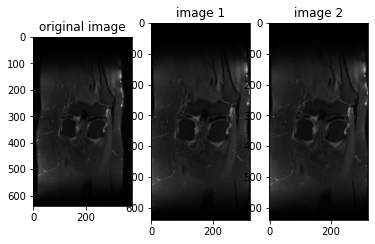

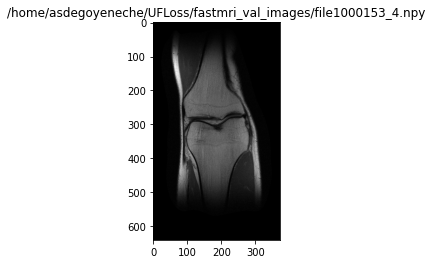

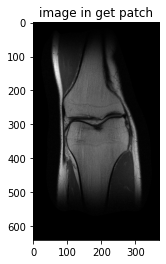

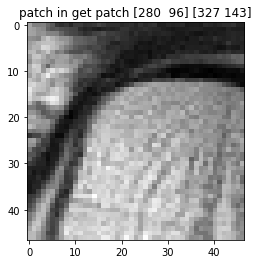

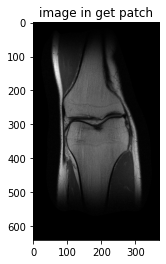

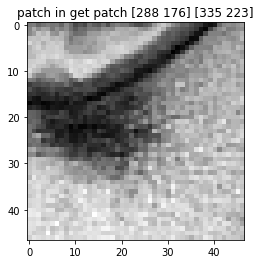

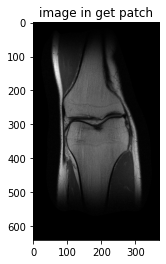

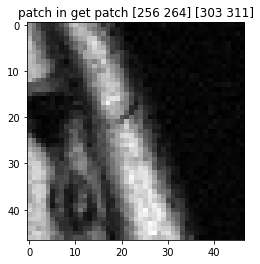

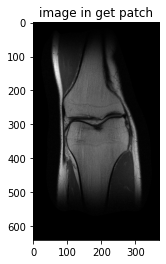

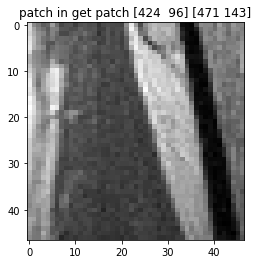

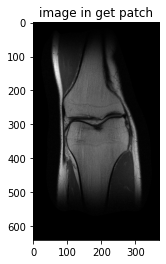

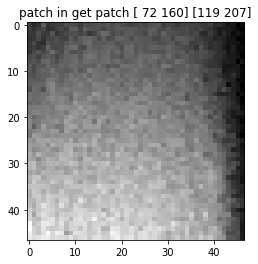

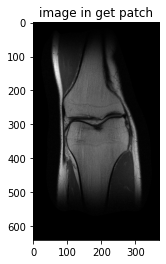

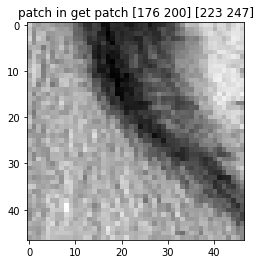

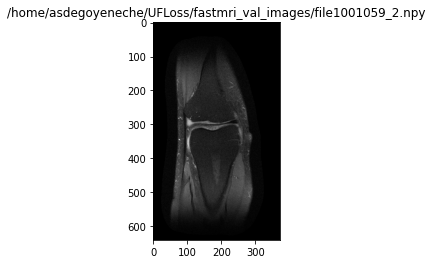

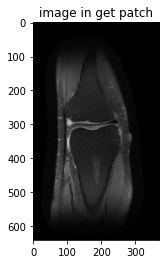

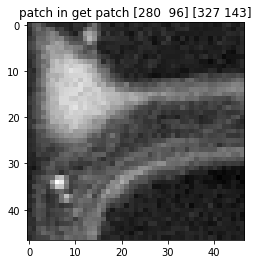

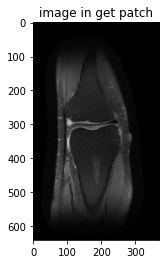

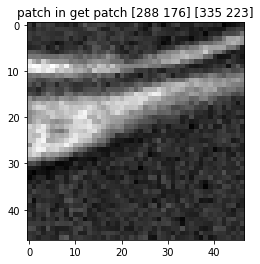

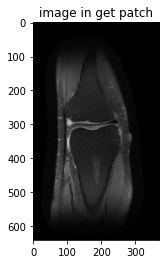

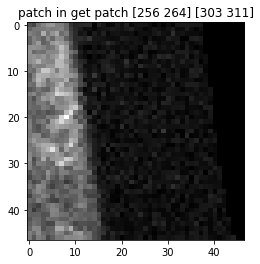

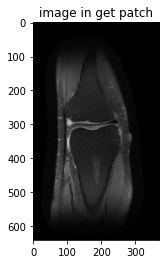

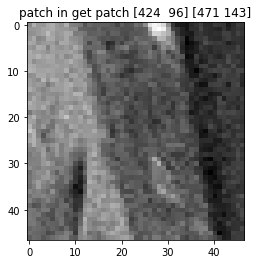

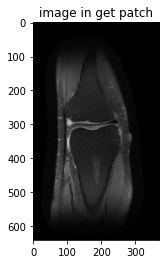

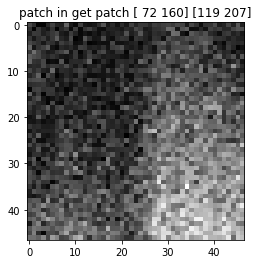

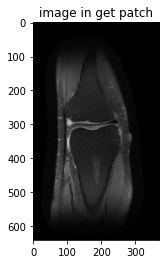

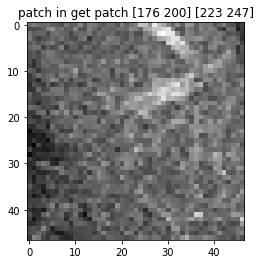

In [194]:
# Get Reference Embeddings

with torch.no_grad():
    reference_image_size = dataset[0][0].shape
    centers_x = np.arange(start, reference_image_size[-2], jump)
    centers_y = np.arange(start, reference_image_size[-1], jump)

    reference_embeddings = []
    for input_path in input_paths:

        reference_image = np.load(input_path)
        reference_image_tensor = torch.from_numpy(reference_image[None])

        if args.magnitude:
            reference_image_tensor = torch.tensor(np.abs(reference_image),
                                              dtype=torch.float).to(device)[None, None]
        else:
            reference_image_tensor = complex2channels(reference_image_tensor)[None]
            
            # reference_image_tensor = torch.tensor(np.stack((reference_image.real, reference_image.imag), 0),
            #                                   dtype=torch.float).to(device)[None]
        
         # percent = (torch.rand(1)*0.1 +0.9).item()
        percent=0.95
        # print(f"percent {percent}")
        reference_image_tensor = normalize(reference_image_tensor, percent)
        
        
        together = torch.complex(reference_image_tensor[:, 0], reference_image_tensor[:, 1])
        print(together.shape)
        plt.figure()
        plt.imshow(torch.abs(together[0]), cmap='gray')
        plt.title(input_path)
        
        reference_image_tensor = reference_image_tensor.to(device)
        
        all_reference_embeddings = ksnet(reference_image_tensor)[0].squeeze(0)

        for patch_center in np.array(patch_centers):
            embedding_indices = np.round((patch_center - start) / jump).astype(np.int32)
            embedding = all_reference_embeddings[:, embedding_indices[0], embedding_indices[1]]

            # Have a set/heap of patches with scores for each reference patch
            reference_embeddings.append(EmbeddingsTopK(embedding, reference_image, embedding_indices,
                                                       centers_x, centers_y))

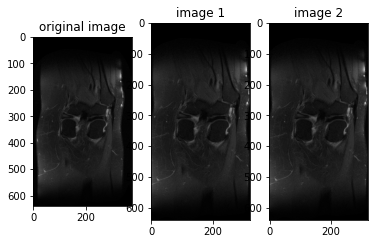

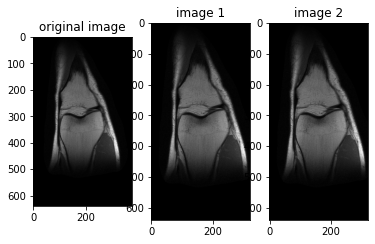

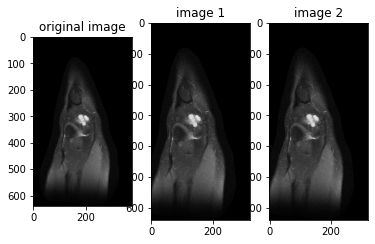

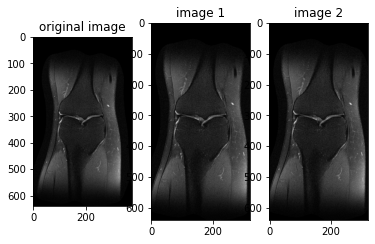

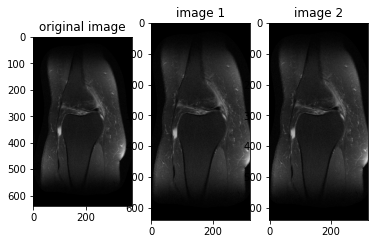

In [195]:
for i in range(5):
    image1, image2 = dataset[i]

Batch:   0%|          | 1/1024 [00:04<1:16:52,  4.51s/it]/home/anacis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
/home/anacis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


torch.Size([5, 2, 640, 320])
tensor([[ 0.0514,  0.0371,  0.0410,  0.0222,  0.0557,  0.0417,  0.0270,  0.0230,
          0.0542,  0.0287],
        [ 0.0970,  0.0846,  0.1047,  0.1233,  0.1610,  0.1276,  0.1268,  0.1366,
          0.1196,  0.1185],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.0908, -0.0948, -0.1242, -0.1089, -0.1294, -0.0907, -0.0927, -0.1006,
         -0.1139, -0.1060]], device='cuda:0')
(640, 320)
torch.Size([640, 320])
torch.Size([47, 47])
(47, 47)
torch.Size([640, 320])
torch.Size([47, 47])
torch.Size([640, 320])
torch.Size([47, 47])
(640, 320)
torch.Size([640, 320])
torch.Size([47, 47])
(47, 47)
torch.Size([640, 320])
torch.Size([47, 47])
torch.Size([640, 320])
torch.Size([47, 47])
(640, 320)
torch.Size([640, 320])
torch.Size([47, 47])
(47, 47)
torch.Size([640, 320])
torch.Size([47, 4

/home/anacis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


torch.Size([640, 320])
torch.Size([47, 47])
(640, 320)
torch.Size([640, 320])
torch.Size([47, 47])
(47, 47)
torch.Size([640, 320])
torch.Size([47, 47])
torch.Size([640, 320])
torch.Size([47, 47])
(640, 320)
torch.Size([640, 320])
torch.Size([47, 47])
(47, 47)
torch.Size([640, 320])
torch.Size([47, 47])
torch.Size([640, 320])
torch.Size([47, 47])
(640, 320)
torch.Size([640, 320])
torch.Size([47, 47])
(47, 47)
torch.Size([640, 320])
torch.Size([47, 47])
torch.Size([640, 320])
torch.Size([47, 47])
(640, 320)
torch.Size([640, 320])
torch.Size([47, 47])
(47, 47)
torch.Size([640, 320])
torch.Size([47, 47])


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f9c096f2630>>
Traceback (most recent call last):
  File "/home/anacis/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/anacis/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1295, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


torch.Size([640, 320])
torch.Size([47, 47])
(640, 320)
torch.Size([640, 320])
torch.Size([47, 47])
(47, 47)
torch.Size([640, 320])
torch.Size([47, 47])
torch.Size([640, 320])
torch.Size([47, 47])
(640, 320)
torch.Size([640, 320])
torch.Size([47, 47])
(47, 47)
torch.Size([640, 320])
torch.Size([47, 47])
torch.Size([640, 320])
torch.Size([47, 47])
(640, 320)
torch.Size([640, 320])
torch.Size([47, 47])
(47, 47)
torch.Size([640, 320])
torch.Size([47, 47])
torch.Size([640, 320])
torch.Size([47, 47])
(640, 320)
torch.Size([640, 320])
torch.Size([47, 47])
(47, 47)
torch.Size([640, 320])
torch.Size([47, 47])
torch.Size([640, 320])
torch.Size([47, 47])
(640, 320)
torch.Size([640, 320])
torch.Size([47, 47])
(47, 47)
torch.Size([640, 320])
torch.Size([47, 47])
torch.Size([640, 320])
torch.Size([47, 47])
(640, 320)
torch.Size([640, 320])
torch.Size([47, 47])
(47, 47)
torch.Size([640, 320])
torch.Size([47, 47])
torch.Size([640, 320])
torch.Size([47, 47])
(640, 320)
torch.Size([640, 320])
torch.Size

Batch:   0%|          | 3/1024 [00:11<1:04:57,  3.82s/it]

(47, 47)
torch.Size([640, 320])
torch.Size([47, 47])
torch.Size([640, 320])
torch.Size([47, 47])


Batch:   0%|          | 3/1024 [00:11<1:07:10,  3.95s/it]


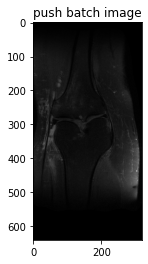

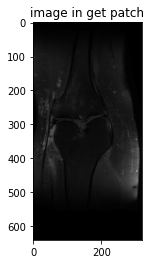

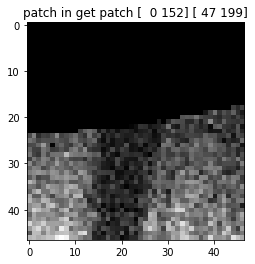

<Figure size 432x288 with 0 Axes>

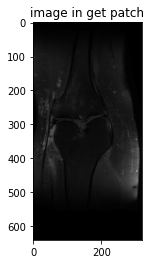

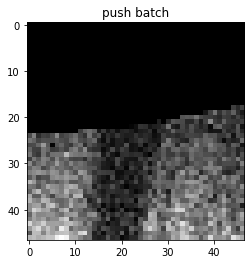

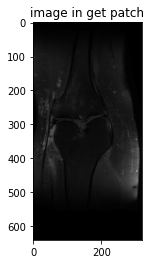

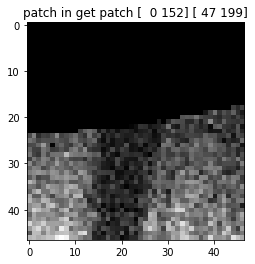

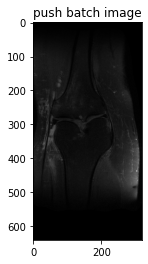

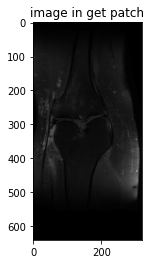

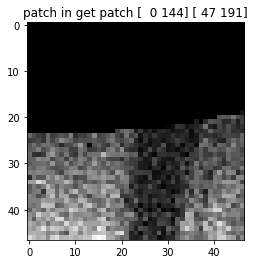

<Figure size 432x288 with 0 Axes>

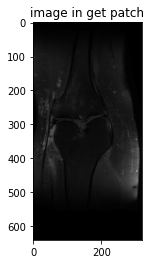

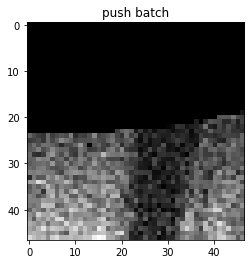

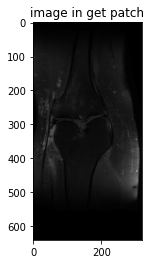

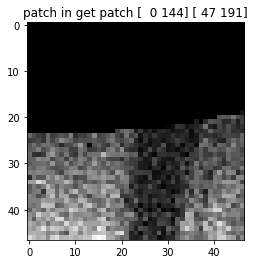

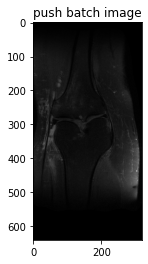

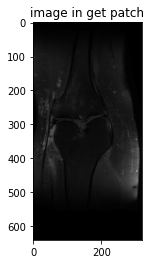

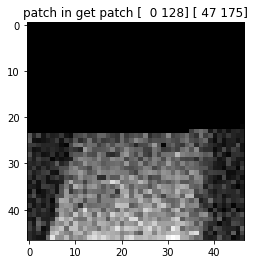

<Figure size 432x288 with 0 Axes>

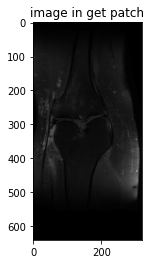

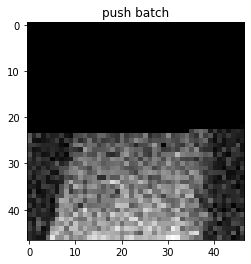

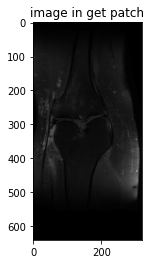

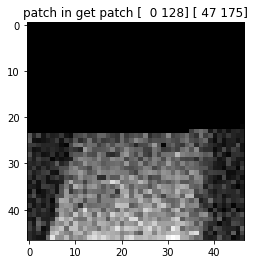

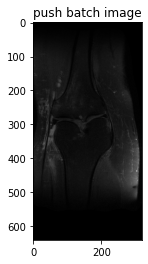

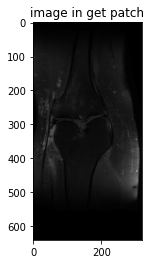

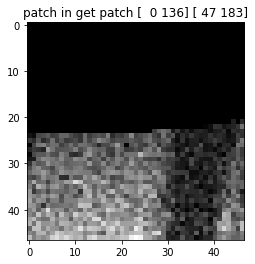

<Figure size 432x288 with 0 Axes>

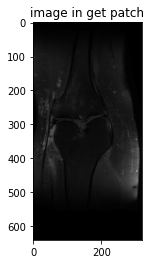

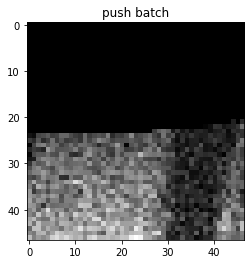

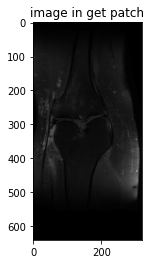

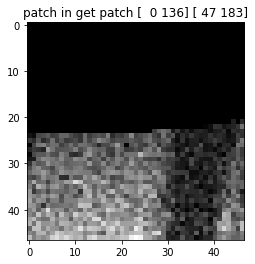

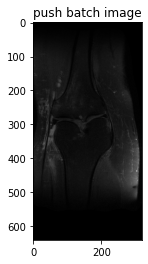

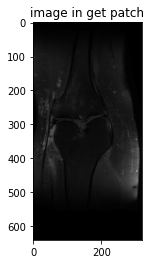

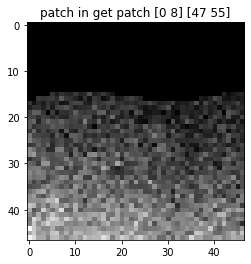

<Figure size 432x288 with 0 Axes>

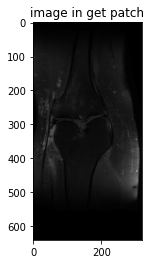

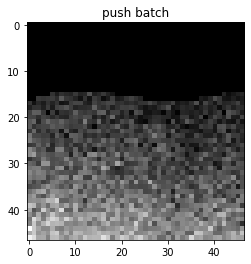

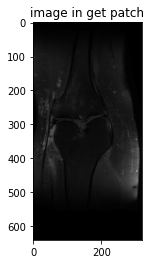

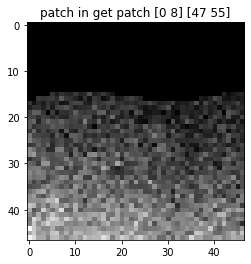

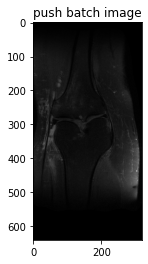

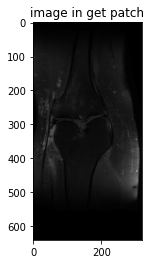

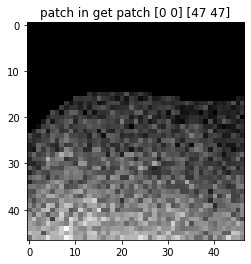

<Figure size 432x288 with 0 Axes>

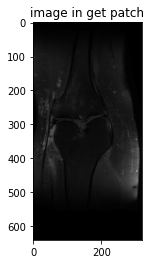

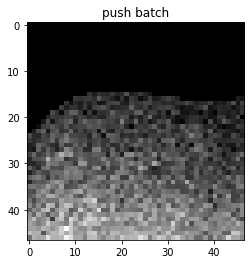

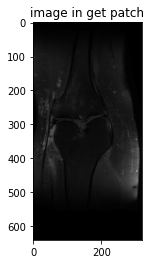

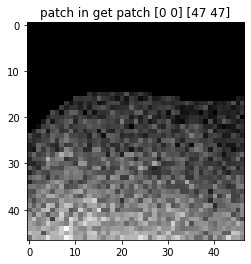

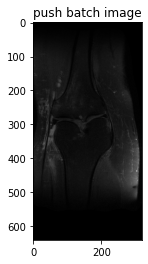

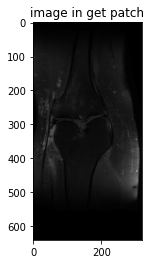

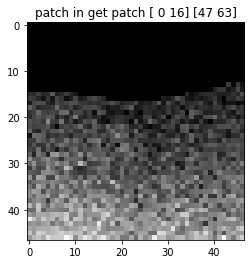

<Figure size 432x288 with 0 Axes>

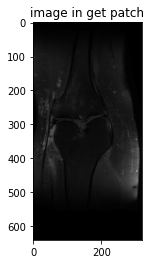

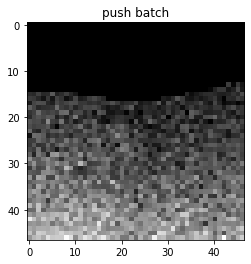

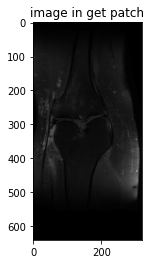

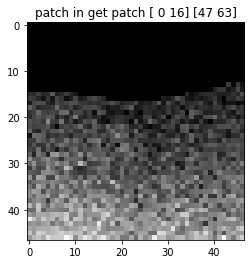

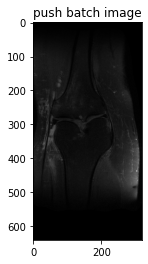

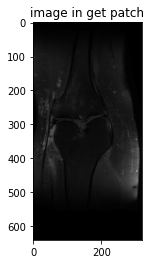

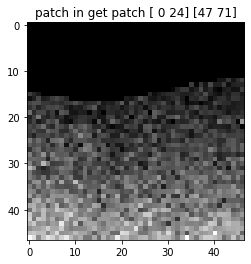

<Figure size 432x288 with 0 Axes>

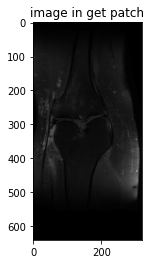

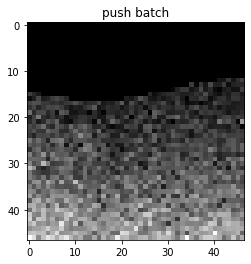

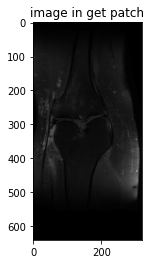

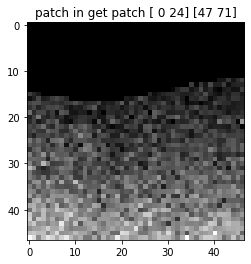

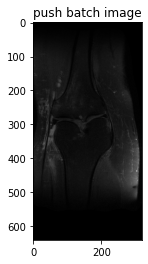

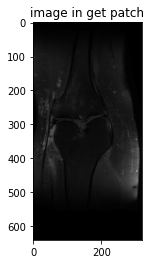

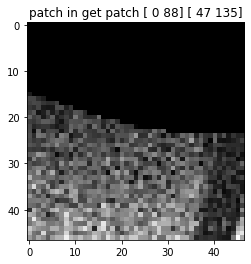

<Figure size 432x288 with 0 Axes>

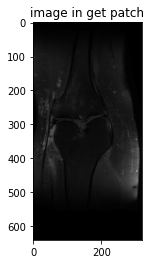

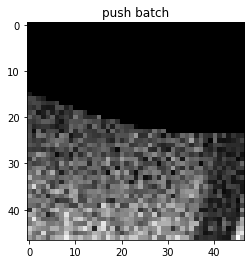

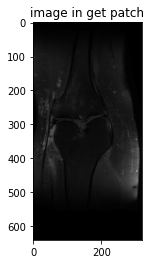

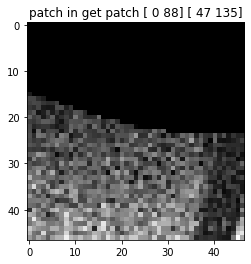

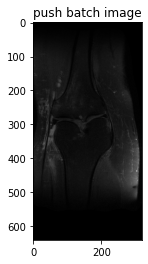

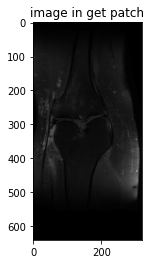

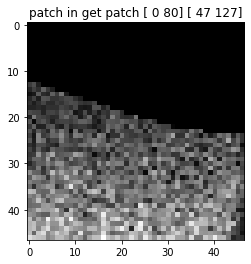

<Figure size 432x288 with 0 Axes>

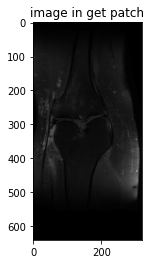

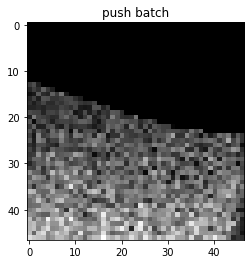

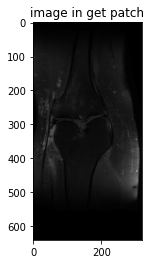

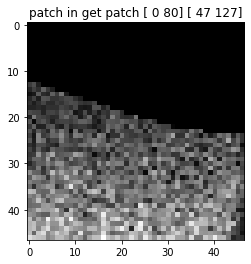

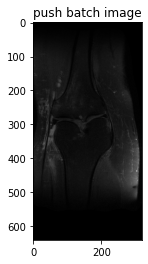

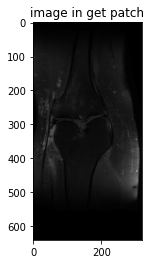

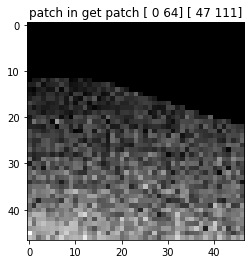

<Figure size 432x288 with 0 Axes>

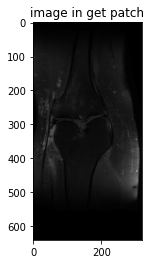

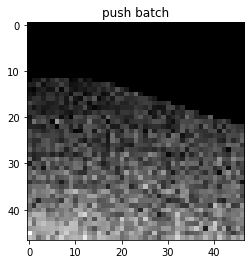

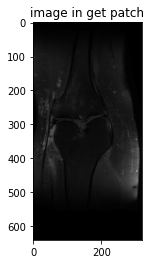

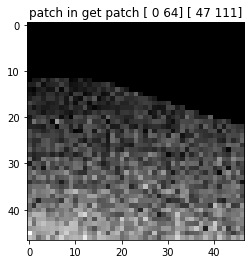

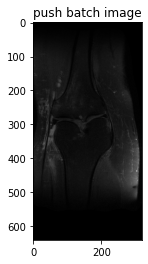

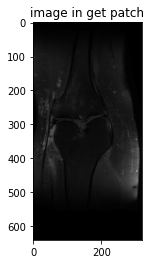

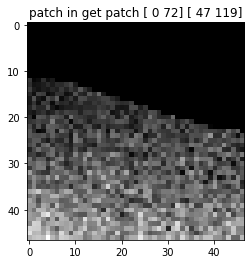

<Figure size 432x288 with 0 Axes>

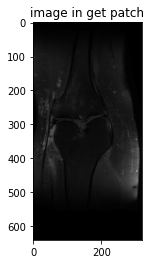

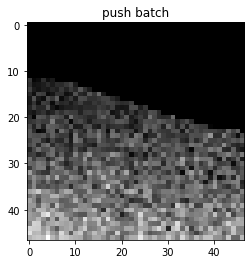

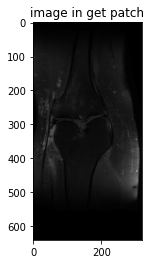

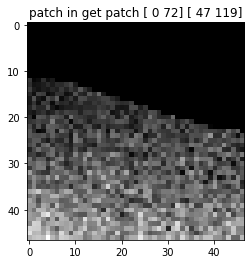

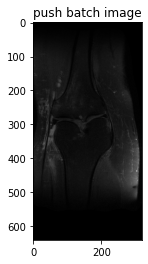

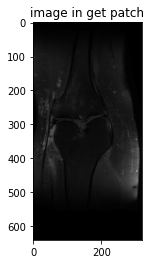

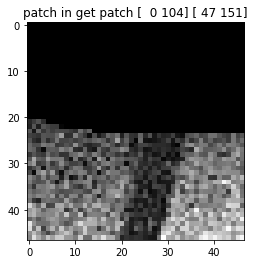

<Figure size 432x288 with 0 Axes>

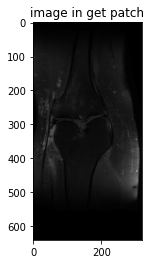

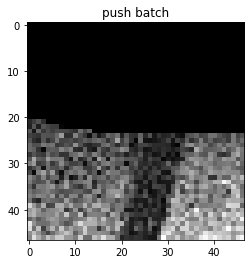

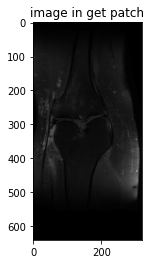

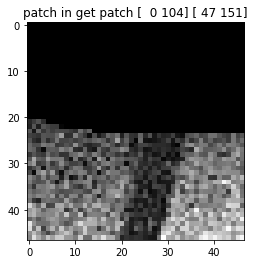

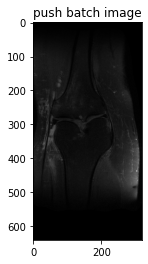

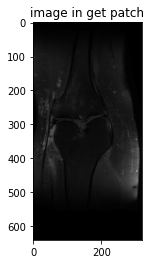

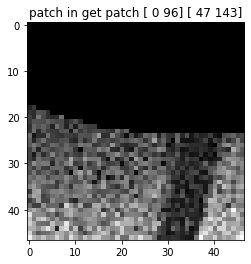

<Figure size 432x288 with 0 Axes>

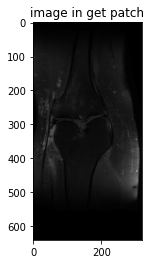

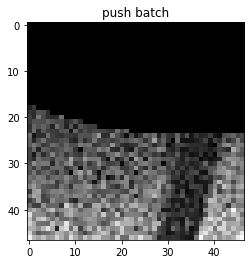

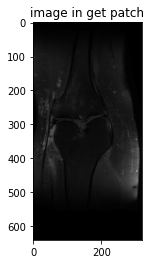

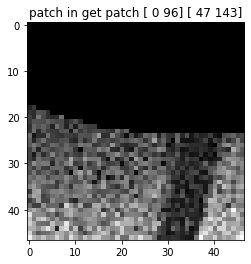

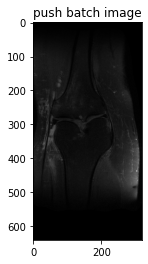

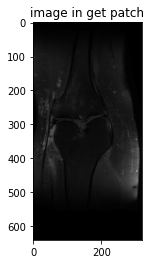

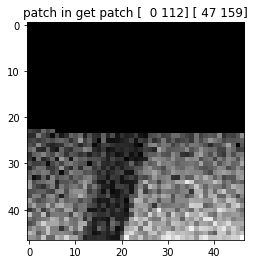

<Figure size 432x288 with 0 Axes>

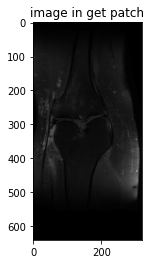

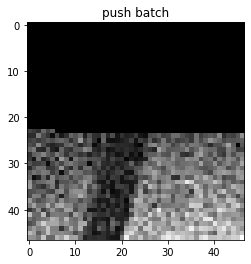

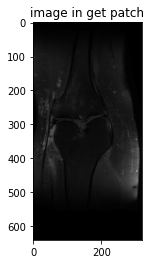

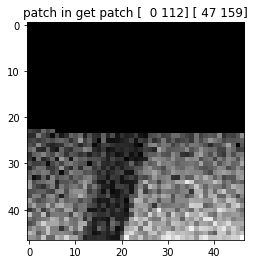

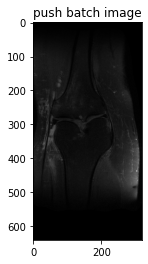

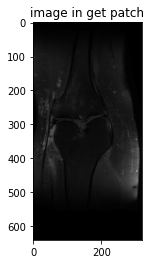

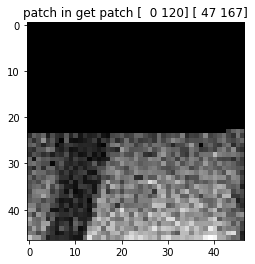

<Figure size 432x288 with 0 Axes>

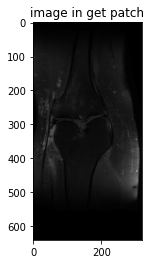

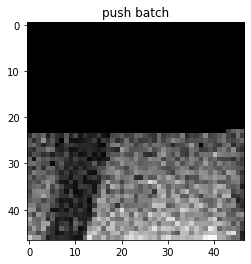

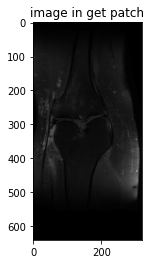

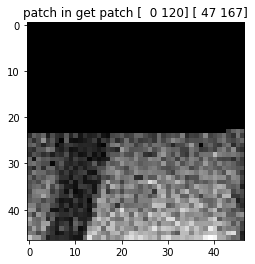

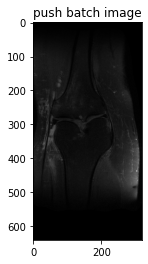

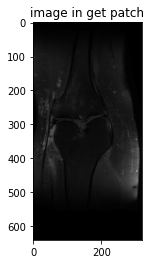

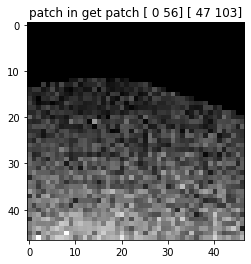

<Figure size 432x288 with 0 Axes>

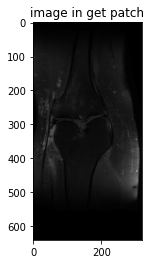

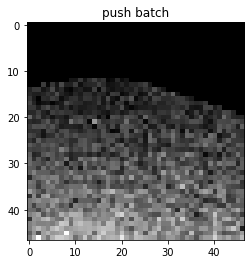

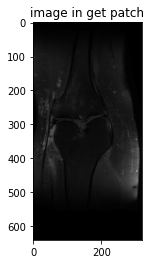

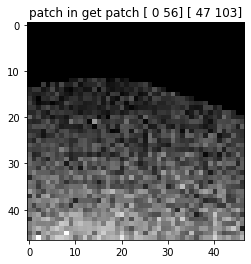

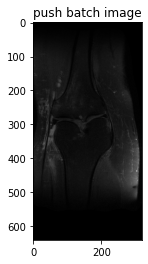

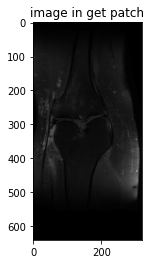

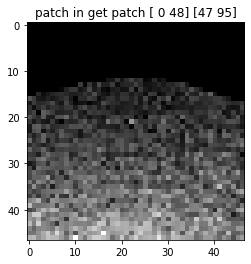

<Figure size 432x288 with 0 Axes>

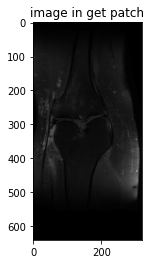

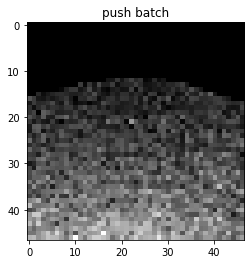

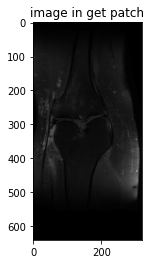

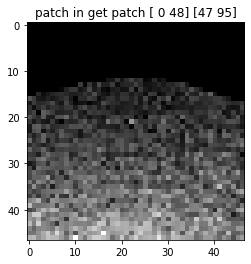

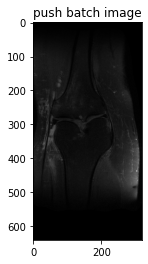

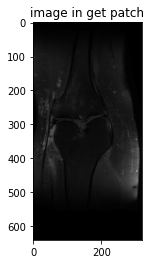

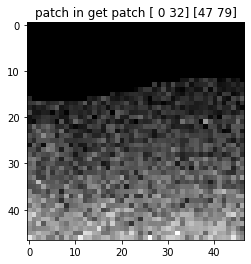

<Figure size 432x288 with 0 Axes>

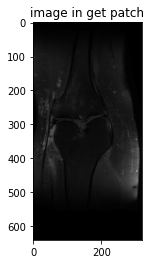

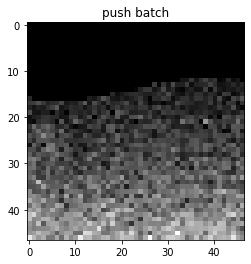

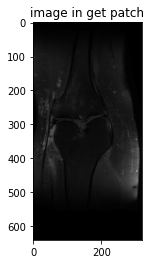

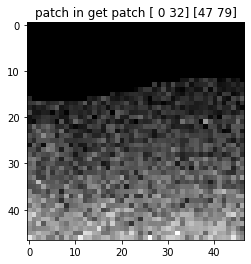

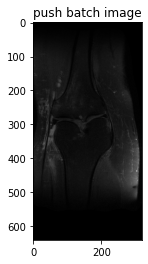

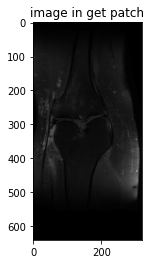

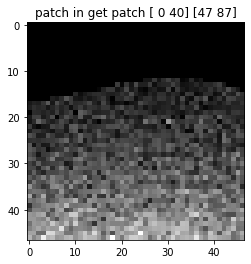

<Figure size 432x288 with 0 Axes>

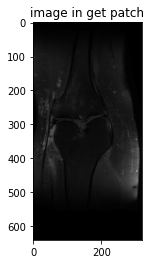

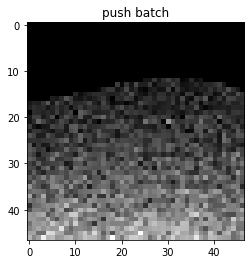

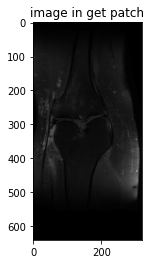

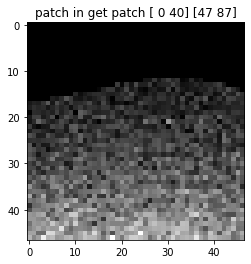

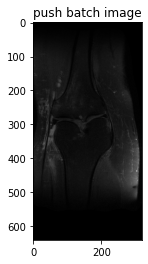

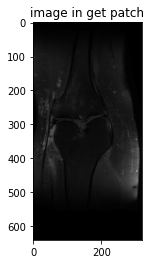

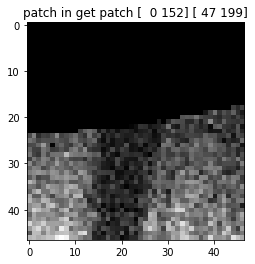

<Figure size 432x288 with 0 Axes>

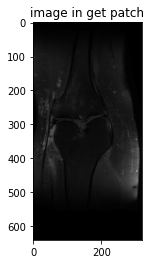

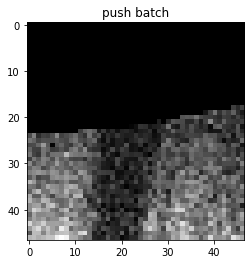

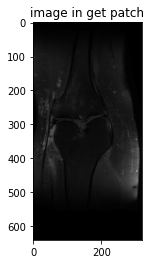

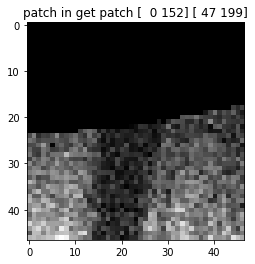

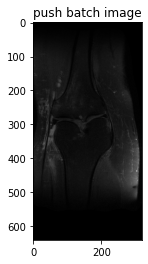

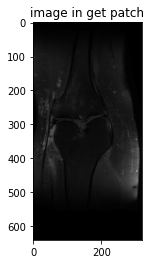

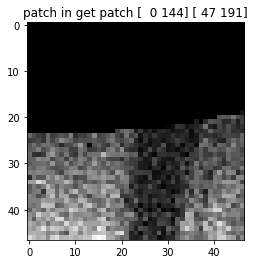

<Figure size 432x288 with 0 Axes>

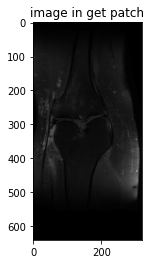

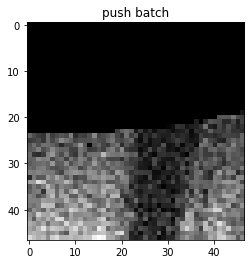

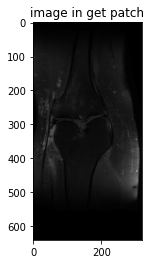

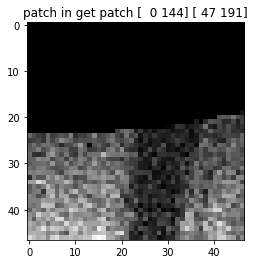

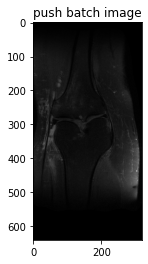

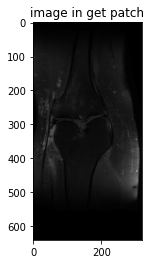

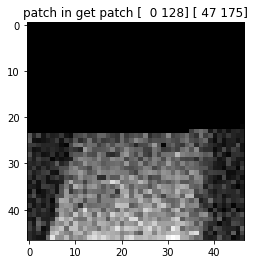

<Figure size 432x288 with 0 Axes>

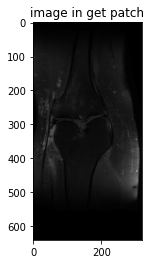

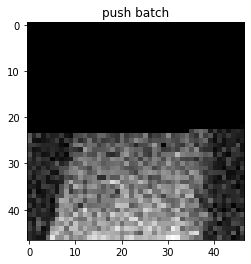

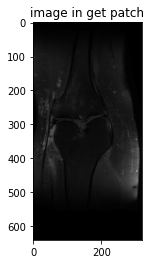

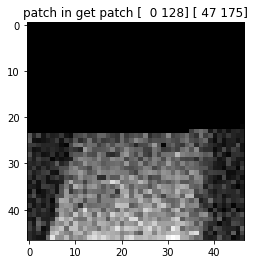

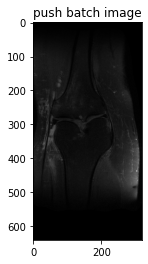

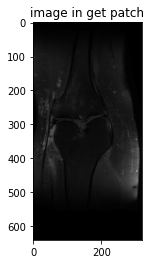

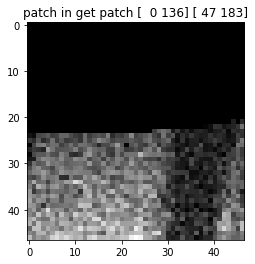

<Figure size 432x288 with 0 Axes>

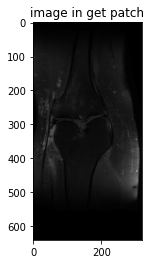

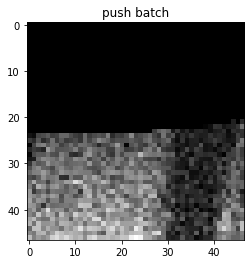

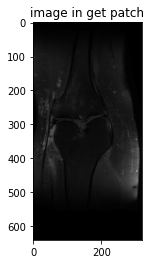

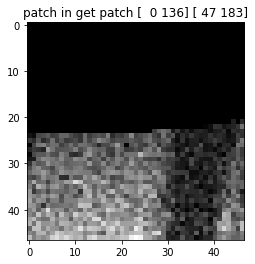

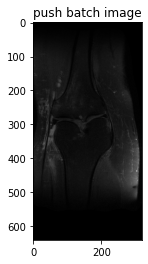

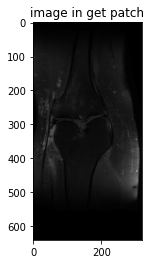

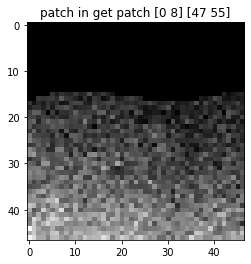

<Figure size 432x288 with 0 Axes>

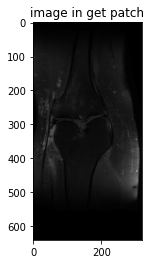

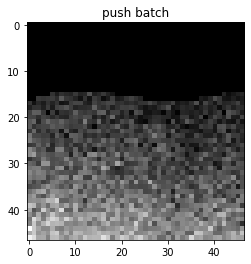

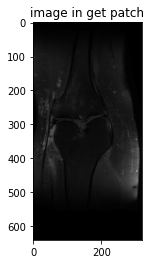

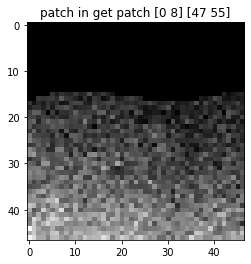

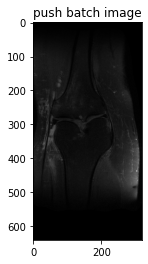

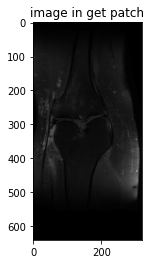

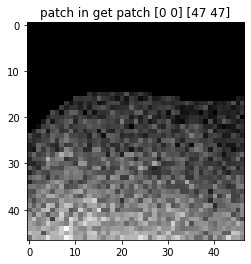

<Figure size 432x288 with 0 Axes>

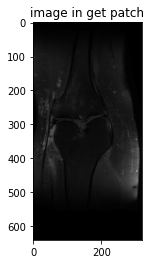

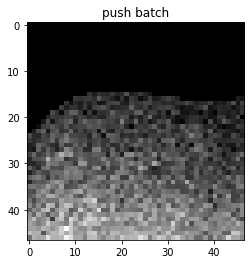

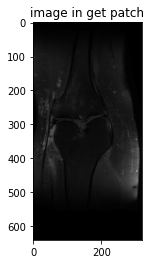

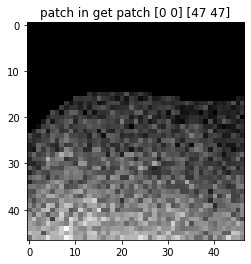

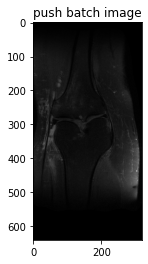

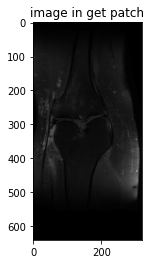

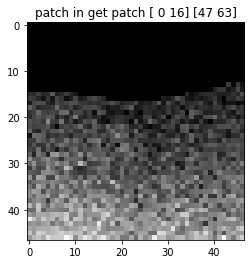

<Figure size 432x288 with 0 Axes>

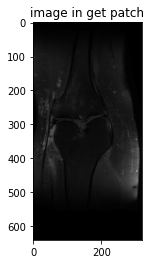

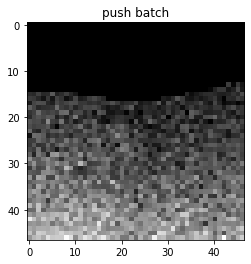

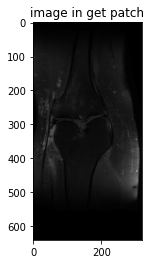

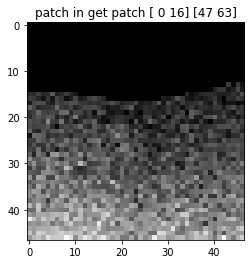

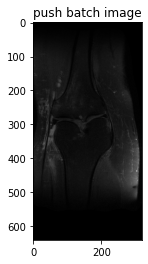

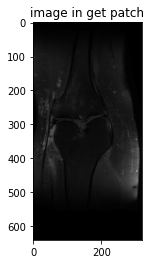

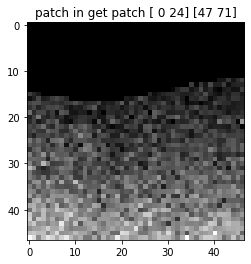

<Figure size 432x288 with 0 Axes>

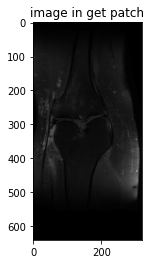

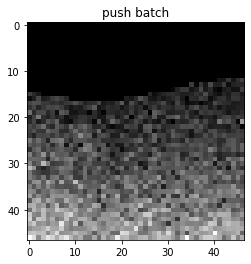

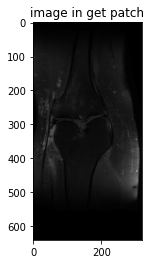

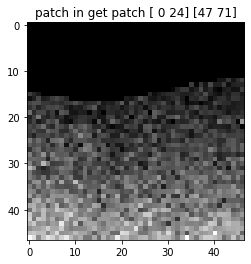

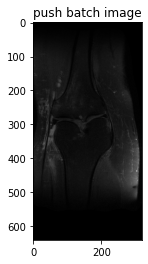

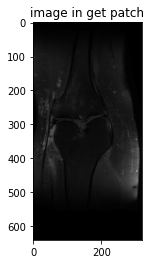

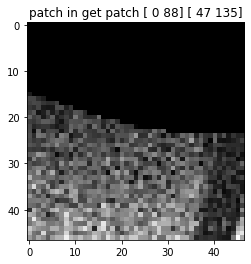

<Figure size 432x288 with 0 Axes>

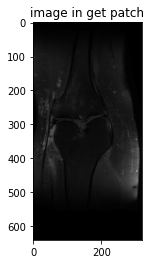

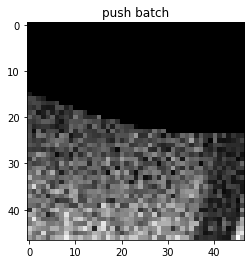

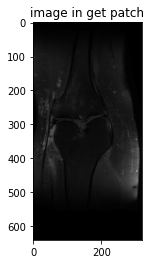

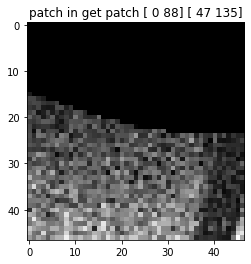

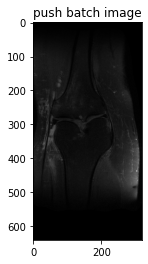

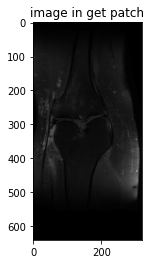

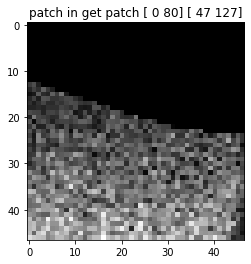

<Figure size 432x288 with 0 Axes>

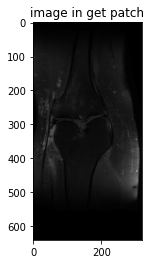

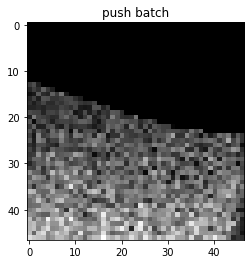

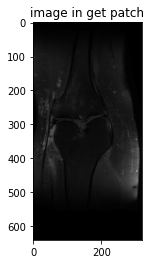

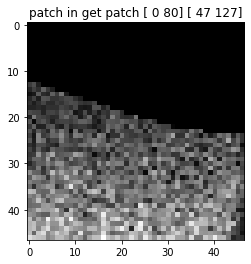

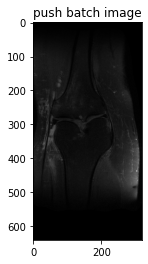

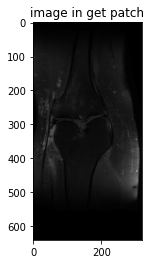

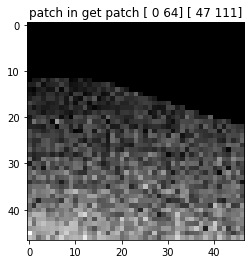

<Figure size 432x288 with 0 Axes>

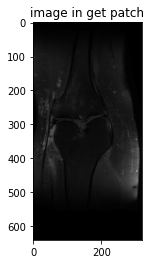

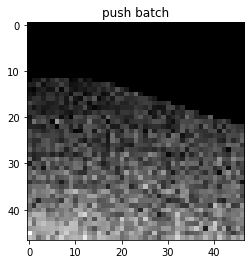

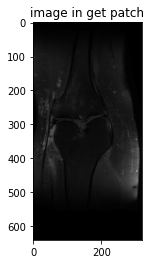

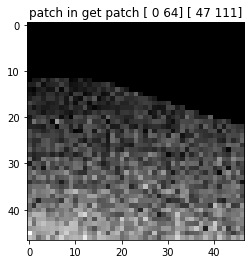

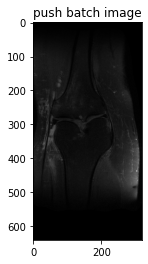

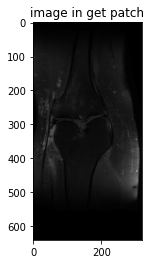

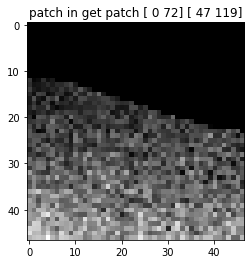

<Figure size 432x288 with 0 Axes>

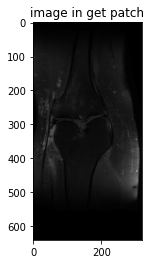

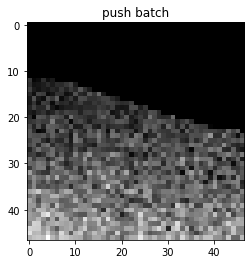

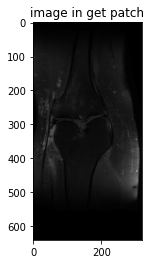

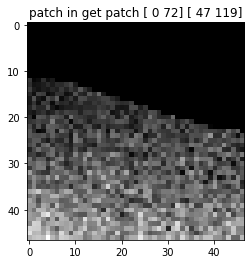

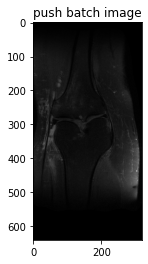

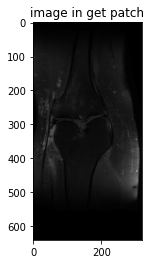

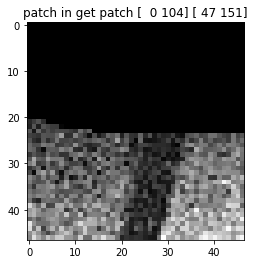

<Figure size 432x288 with 0 Axes>

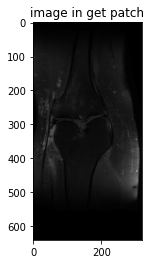

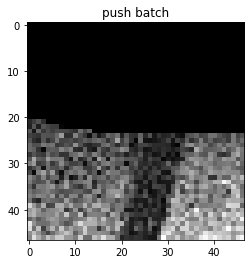

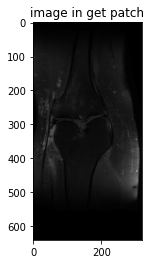

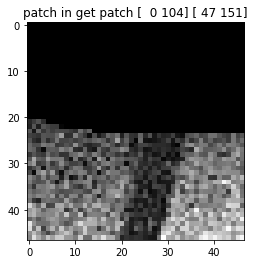

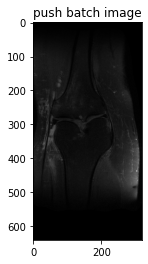

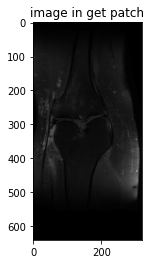

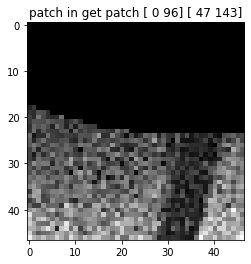

<Figure size 432x288 with 0 Axes>

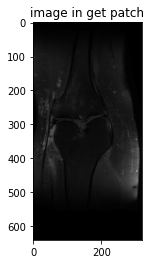

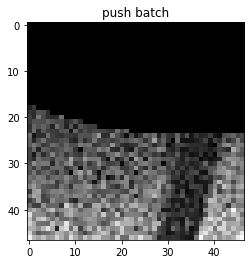

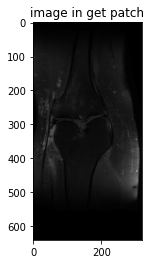

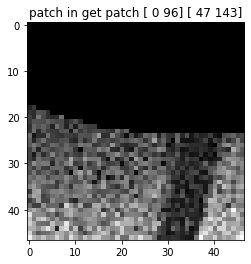

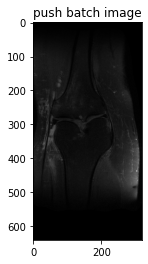

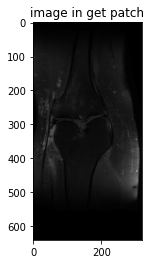

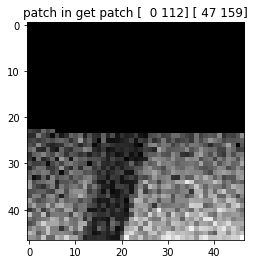

<Figure size 432x288 with 0 Axes>

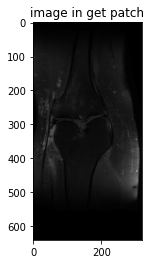

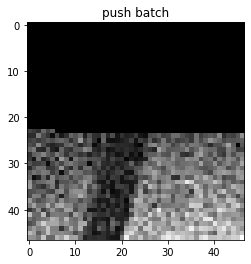

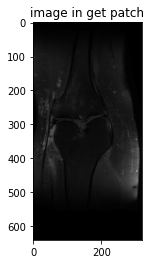

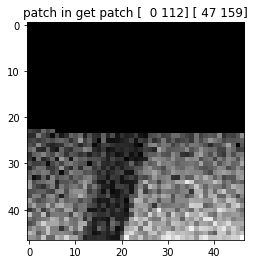

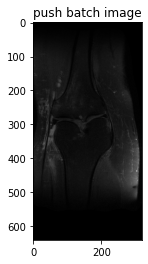

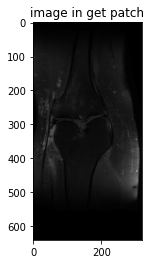

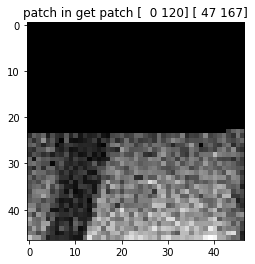

<Figure size 432x288 with 0 Axes>

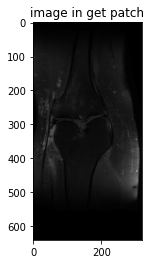

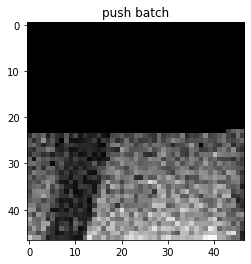

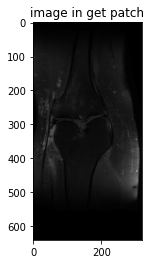

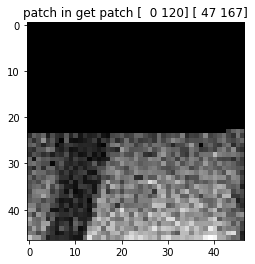

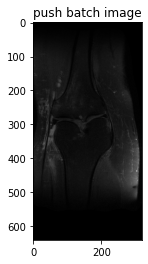

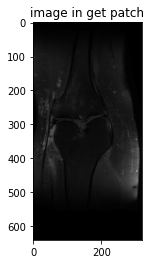

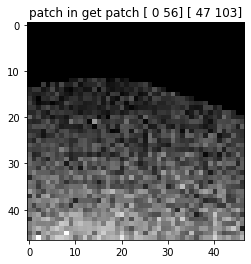

<Figure size 432x288 with 0 Axes>

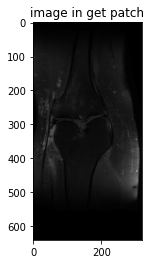

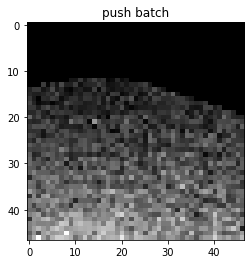

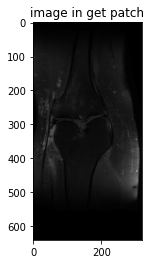

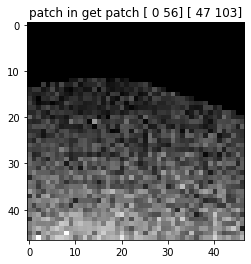

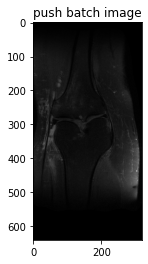

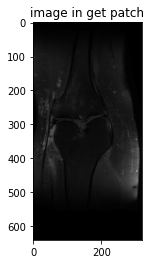

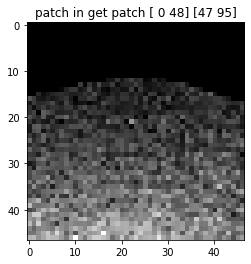

<Figure size 432x288 with 0 Axes>

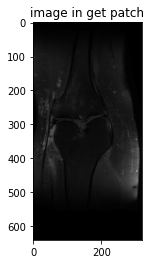

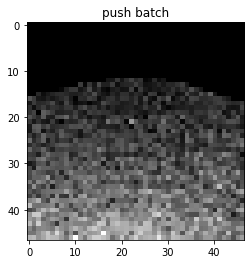

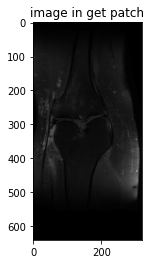

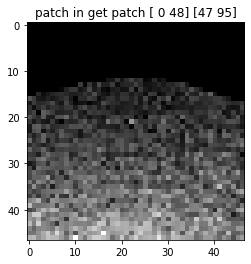

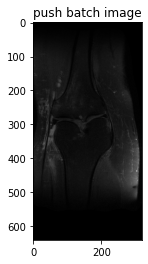

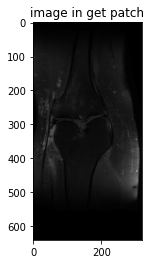

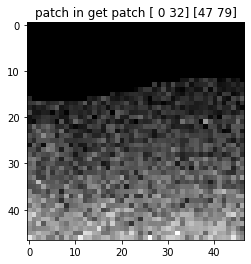

<Figure size 432x288 with 0 Axes>

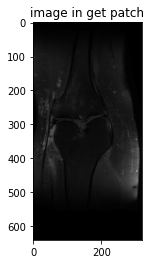

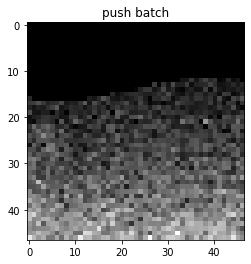

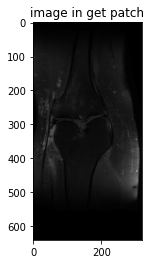

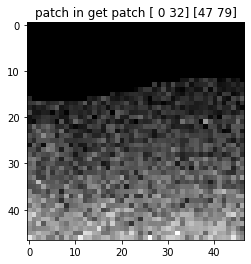

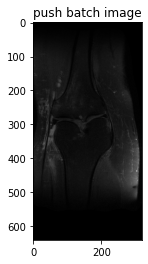

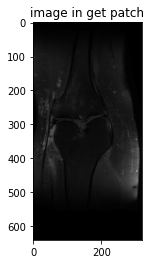

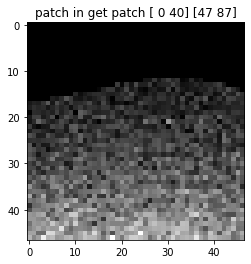

<Figure size 432x288 with 0 Axes>

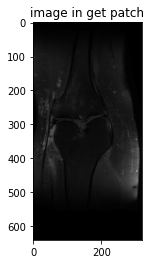

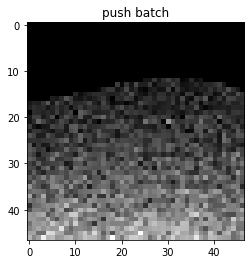

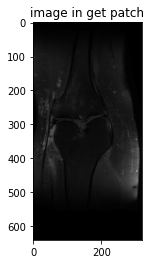

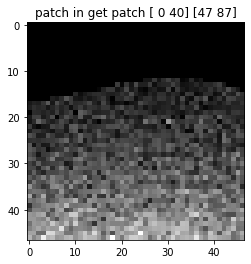

In [216]:
all_embeddings = []
all_images = []

with torch.no_grad():
    limit = 2
    for i, images in enumerate(tqdm(dataloader, "Batch")):
        if i < limit:
            continue
        elif i == limit:
            for image in images:  # image1 and image2 with different augmentations      
                image = image.to(device)
                embeddings = ksnet(image)[0]
                print(image.shape)
                print(image[:, 0, 100:110, 100])

                for reference in reference_embeddings[:1]:
                    reference.push_batch(embeddings, image)
                    embeddings.detach()
                    image.detach()
        elif i > limit:
            break